#Necessary Imports

In [84]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
# import glob
import math

#Reading The Image

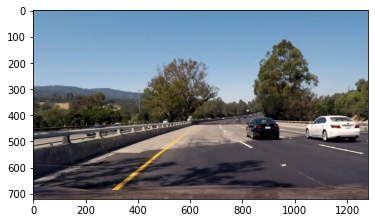

In [114]:
image = cv2.imread("test1.jpg")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [115]:
height = image.shape[0]
print(height)
width = image.shape[1]
print(width)

720
1280


#Functions

In [116]:
def show_image(image, title="title", cmap_type="gray"):
    plt.imshow(image, cmap_type)
    plt.title(title)

In [117]:
# applying gaussian blur
def gaussian_blur(image,height,width):
    return cv2.GaussianBlur(image,(height, width),0)

In [118]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    match_mask_color = 255
    
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


In [119]:
region_of_interest_vertices = [
    (0, height),
    (width / 2,400),
    (width, height),
]

#Using Grayscale, Gaussian Blur, Cropping the image and using binary threshold

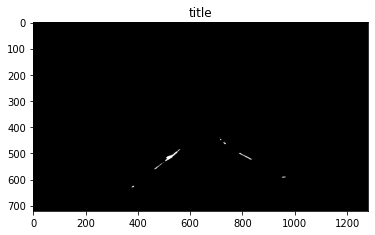

In [120]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#cannyed_image = cv2.Canny(gray,100,200, L2gradient = True)
blurred = gaussian_blur(gray,7,7)
cropped_image = region_of_interest(
    blurred,
    np.array([region_of_interest_vertices], np.int32)
)

(T, threshInv) = cv2.threshold(cropped_image, 200, 255,cv2.THRESH_BINARY)
#cv2.imshow("Threshold Binary Inverse", threshInv)
show_image(threshInv)

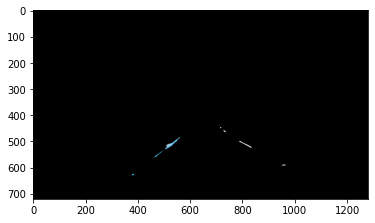

In [121]:
masked = cv2.bitwise_and(image, image, mask=threshInv)
plt.imshow(masked)

#show_image(masked)

#Sobel Transform and binary Image

In [122]:
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

gray = hls[:, :, 1]

s_channel = hls[:, :, 2]

In [123]:
sobel_kernel=7
mag_thresh=(3, 255)
s_thresh=(170, 255)
th=(10,100)

In [124]:
sobel_binary = np.zeros(shape=gray.shape, dtype=bool)
s_binary = sobel_binary
combined_binary = s_binary.astype(np.float32)

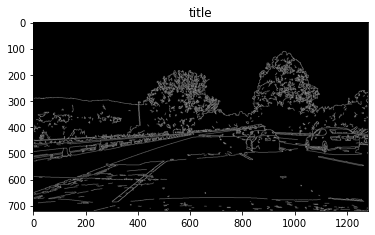

In [125]:
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=7)
sobely = 0
#sobelxy = cv2.Sobel(gray, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=7)
show_image(sobelx)
edges = cv2.Canny(gray, threshold1=100, threshold2=200) # Canny Edge Detection
# Display Canny Edge Detection Image
show_image(edges)

In [126]:
sobel_abs = np.abs(sobelx**2 + sobely**2)
sobel_abs = np.uint8(255 * sobel_abs / np.max(sobel_abs))

In [127]:
sobel_binary[(sobel_abs > mag_thresh[0]) & (sobel_abs <= mag_thresh[1])] = 1

# Threshold color channel
s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

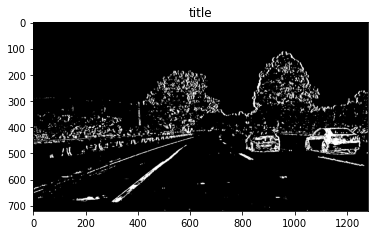

In [128]:
combined_binary[(s_binary == 1) | (sobel_binary == 1)] = 1
combined_binary = np.uint8(255 * combined_binary / np.max(combined_binary))
show_image(combined_binary)

In [129]:
def masked_image(combined_binary):
    offset = 100
    mask_poly =np.array([[(0 + offset, image.shape[0]),
                            (image.shape[1] / 2.3, image.shape[0] / 1.65),
                            (image.shape[1] / 1.7, image.shape[0] / 1.65),
                            (image.shape[1], image.shape[0])]],
                          dtype=int)
    mask_img = np.zeros_like(combined_binary)
    ignore_mask_color = 255
    cv2.fillPoly(mask_img, mask_poly, ignore_mask_color)
    masked_edges = cv2.bitwise_and(combined_binary, mask_img)
    return masked_edges

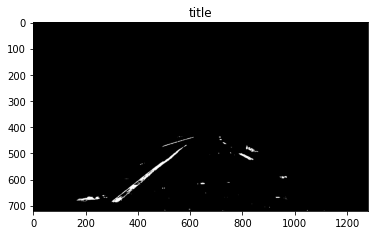

In [130]:
show_image(masked_image(combined_binary))

#Src and dst Points

In [131]:
src = [595, 452], \
          [685, 452], \
          [1110, image.shape[0]], \
          [220, image.shape[0]]
line_dst_offset = 100
dst = [src[3][0] + line_dst_offset, 0], \
          [src[2][0] - line_dst_offset, 0], \
          [src[2][0] - line_dst_offset, src[2][1]], \
          [src[3][0] + line_dst_offset, src[3][1]]

#Perspective Transform Function

In [103]:
def warp(image, src, dst):

    src = np.float32([src])
    dst = np.float32([dst])
    
    return cv2.warpPerspective(image, cv2.getPerspectiveTransform(src, dst),
                               dsize=image.shape[0:2][::-1], flags=cv2.INTER_LINEAR)

#Using Sobel and Binary Image 

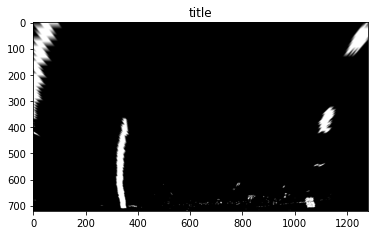

In [104]:
Perspective_img1=(warp(combined_binary,src,dst))
show_image(Perspective_img1)

#Using Gaussian Blur and Binary Thresholding 

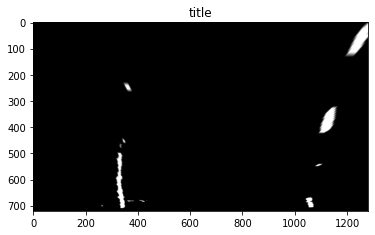

In [105]:
Perspective_img=(warp(threshInv,src,dst))
show_image(Perspective_img)

#Inverse Perspective Transform

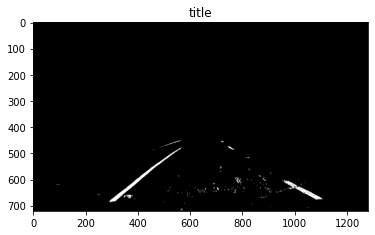

In [106]:
show_image(warp(Perspective_img1,dst,src))

In [107]:
def get_warped_image_histogram(image):
    return np.sum(image[image.shape[0] // 2:, :], axis=0)

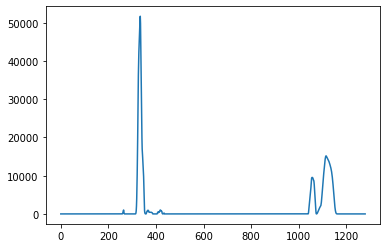

In [108]:
histogram = get_warped_image_histogram(Perspective_img)
plt.plot(histogram)
plt.show()

In [109]:
def sliding_window(image, n_windows=9):
    # Get Binary image histogram
    histogram = get_warped_image_histogram(image)
    
    # Allow image to be RGB to display sliding windows.
    out = np.dstack((image, image, image)) * 255
    
    # Get Center of left and right peaks.
    midpoint = histogram.shape[0] // 2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Calculate window height.
    window_height = image.shape[0] // n_windows
    
    # Get indicies that map to non zero values.
    non_zero_y, non_zero_x = map(lambda x: np.array(x), image.nonzero())
    
    margin = 50 # Width of sliding window.
    min_pixels = 50 # Min amount of pixels that match inside the window to detect a lane.
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    left_lane_indicies = []
    right_lane_indicies = []
    
    for window in range(n_windows):
        # Calculate window vertices positions.
        win_y_low = image.shape[0] - (window + 1) * window_height # Y coordinate of top corners. 
        win_y_high = image.shape[0] - window * window_height # Y coordinate of bottom corners.
        win_xleft_low = leftx_current - margin # X coordinate of left side of the window at the left side of the lane.
        win_xleft_high = leftx_current + margin # X coordinate of right side of the window at the left side of the lane.
        win_xright_low = rightx_current - margin # X coordinate of left side of the window at the right side of the lane.
        win_xright_high = rightx_current + margin # X coordinate of right side of the window at the right side of the lane.
        
        # Draw green rectangle at current windows.
        cv2.rectangle(out, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        
        good_left_indicies = ((non_zero_y >= win_y_low) & (non_zero_y < win_y_high) & (non_zero_x >= win_xleft_low) & (
            non_zero_x < win_xleft_high)).nonzero()[0] # Check if index is inside the left window.
        good_right_indicies = ((non_zero_y >= win_y_low) & (non_zero_y < win_y_high) & (non_zero_x >= win_xright_low) & (
            non_zero_x < win_xright_high)).nonzero()[0] # Check if index is inside the right window.
        
        left_lane_indicies.append(good_left_indicies)
        right_lane_indicies.append(good_right_indicies)
        
        # Shift left to the mean.
        if len(good_left_indicies) > min_pixels:
            leftx_current = int(np.mean(non_zero_x[good_left_indicies]))
        if len(good_right_indicies) > min_pixels:
            rightx_current = int(np.mean(non_zero_x[good_right_indicies]))
    
    left_lane_indicies = np.concatenate(left_lane_indicies)
    right_lane_indicies = np.concatenate(right_lane_indicies)

    # Pixels that matched in the left side of the lane.
    left_x = non_zero_x[left_lane_indicies]
    left_y = non_zero_y[left_lane_indicies]
    
    # Pixels that matched in the right side of the lane.
    right_x = non_zero_x[right_lane_indicies]
    right_y = non_zero_y[right_lane_indicies]

    # Fit the points using a second degree polynomial.
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)
        
    return out, left_fit, right_fit

In [110]:
def draw_lines_and_fill(image, warped_image, left_fit, right_fit, src, dest):
    
    # Make a zero like copy of warped image.
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    
    # Make rgb image of zeros.
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Create a y axis.
    ploty = np.linspace(0, image.shape[0] - 1, image.shape[0])
        
    # Left line polynomial.
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    # Right Line polynomial.
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(color_warp_center, np.int_([pts]), (0, 255, 0))
    cv2.fillPoly(color_warp, np.int_([pts]), (255, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warp(color_warp, dest, src)
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.2, 0)

    color_warp_lines = np.dstack((warp_zero, warp_zero, warp_zero))
    cv2.polylines(color_warp_lines, np.int_([pts_left]), isClosed=False, color=(0, 0, 255), thickness=25)
    cv2.polylines(color_warp_lines, np.int_([pts_right]), isClosed=False, color=(0, 0, 255), thickness=25)
    newwarp_lines = warp(color_warp_lines, dest, src)

    result = cv2.addWeighted(result, 1, newwarp_lines, 1, 0)

    return result

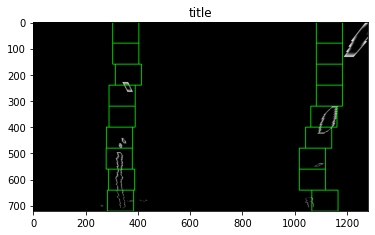

In [111]:
image_with_sliding_window, left_fit, right_fit = sliding_window(Perspective_img)
show_image(image_with_sliding_window)

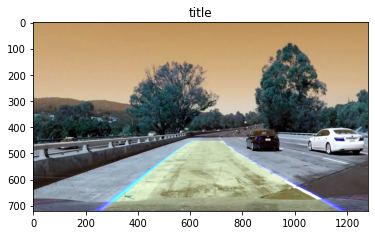

In [113]:
final_image = draw_lines_and_fill(image, Perspective_img, left_fit, right_fit, src, dst)
show_image(final_image)